# SVM

Use a standard SVM on 300d glove. Moved from glove.ipynb because I ran out of memory.

In [1]:
# Save these files so I don't have to do this again
import csv
def load_tokenized(path):
    with open(path, 'r') as f:
        reader = csv.reader(f, delimiter='|')
        sentences = []
        for row in reader:
            sentences.append(row)
        return sentences

q1_word_tokenized = load_tokenized('../data/train_q1.txt')
q2_word_tokenized = load_tokenized('../data/train_q2.txt')

In [2]:
is_duplicate = [int(x.strip()) for x in open('../data/train_is_duplicate.txt')]
is_duplicate[3355:3365]

[1, 0, 0, 0, 0, 1, 0, 1, 1, 1]

In [3]:
import numpy as np

def load_embeddings(filepath):
    embeddings = {}
    current_word = 0
    rows = []
    
    with open(filepath, "rb") as f:
        for line in f:
            line = line.decode("utf-8")
            elements = line.strip().split(' ', 1)
            word = elements[0]
            vector = [float(x) for x in elements[1].split(' ')]
            vector = np.array(vector)
            
            word_id = current_word
            current_word += 1
            embeddings[word] = word_id
            rows.append(vector)
    return embeddings, np.stack(rows, axis=0)

In [4]:
# What about 300d GloVe?
embeddings300, array300 = load_embeddings("../data/glove.6B.300d.txt")
print(array300.shape)

(400000, 300)


In [5]:
print(len(embeddings300))

400000


In [6]:
def get_paragraph_embedding(paragraph,
                            dictionary,
                            embeddings,
                            ignore_unknown=True,
                            unknown_embedding=None):
    '''Return a paragraph embedding as an average of its word embeddings.'''
    embedding_size = embeddings[dictionary['the'],:].shape[0] # autodetect
    paragraph_embedding = np.zeros(embedding_size)
    count_words = 0
    for word in paragraph:
        if word in dictionary:
            we = embeddings[dictionary[word]]
            paragraph_embedding += we
            count_words += 1
        elif not ignore_unknown:
            we = unknown_embedding
            paragraph_embedding += we
            count_words += 1
    if count_words == 0:
        paragraph_embedding = paragraph_embedding
    else:
        paragraph_embedding = paragraph_embedding / count_words
    return paragraph_embedding

In [7]:
q1_emb300 = []
q2_emb300 = []
for q1 in q1_word_tokenized:
    e = get_paragraph_embedding(q1, embeddings300, array300, ignore_unknown=True)
    q1_emb300.append(e)
for q2 in q2_word_tokenized:
    e = get_paragraph_embedding(q2, embeddings300, array300, ignore_unknown=True)
    q2_emb300.append(e)
q1_emb300 = np.stack(q1_emb300)
q2_emb300 = np.stack(q2_emb300)
print(q1_emb300.shape)
print(q2_emb300.shape)

(404288, 300)
(404288, 300)


In [8]:
q1q2 = np.concatenate([q1_emb300, q2_emb300], axis=1)
print(q1q2.shape)

(404288, 600)


Save memory:

In [9]:
del q1_emb300
del q2_emb300

# Checkpoint

At this point we have:
1. ``is_duplicate``: python list, values $\in \{0, 1\}$
1. ``q1q2``: np.Array, $\mathbb{R}^{400,000 \times 600}$

In [10]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer

rand = 33

X = q1q2
y = is_duplicate
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.4, random_state=rand)

nrm = Normalizer()
X_train = nrm.fit_transform(X_train)
X_valid = nrm.transform(X_valid)

In [11]:
# These numbers take a while to generate. Let's save them.
# It turns out they're pretty big, lol
np.savetxt('../data/train_X_train.txt', X_train)
np.savetxt('../data/train_X_valid.txt', X_valid)
np.savetxt('../data/train_y_train.txt', y_train)
np.savetxt('../data/train_y_valid.txt', y_valid)

In [12]:
# At this point we have a problem: too many examples!
# Idea #1: bagged SVM
indices = range(len(X_train))

In [22]:
from __future__ import print_function
bag_num = 20
examples_per_bag = 1000
models = []

C=1.0

for i in range(bag_num):
    print('Model:', i)
    np.random.shuffle(indices)
    i_bag = indices[:examples_per_bag]
    X_bag = X[i_bag]
    y_bag = [y[i] for i in i_bag]
    svm = LinearSVC()
    svm.fit(X_bag, y_bag)
    models.append(svm)

Model: 0
Model: 1
Model: 2
Model: 3
Model: 4
Model: 5
Model: 6
Model: 7
Model: 8
Model: 9
Model: 10
Model: 11
Model: 12
Model: 13
Model: 14
Model: 15
Model: 16
Model: 17
Model: 18
Model: 19


# Evaluation

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets.samples_generator import make_blobs
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['figure.dpi'] = 100

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [29]:
decision_one = lambda svm, x: svm.decision_function(x)
decisions = [decision_one(svm, X_valid) for svm in models]
aggregate = np.mean(np.stack(decisions, axis=1), axis=1)
print(aggregate.shape)

(161716,)


-1.72331301794
-0.792021057983


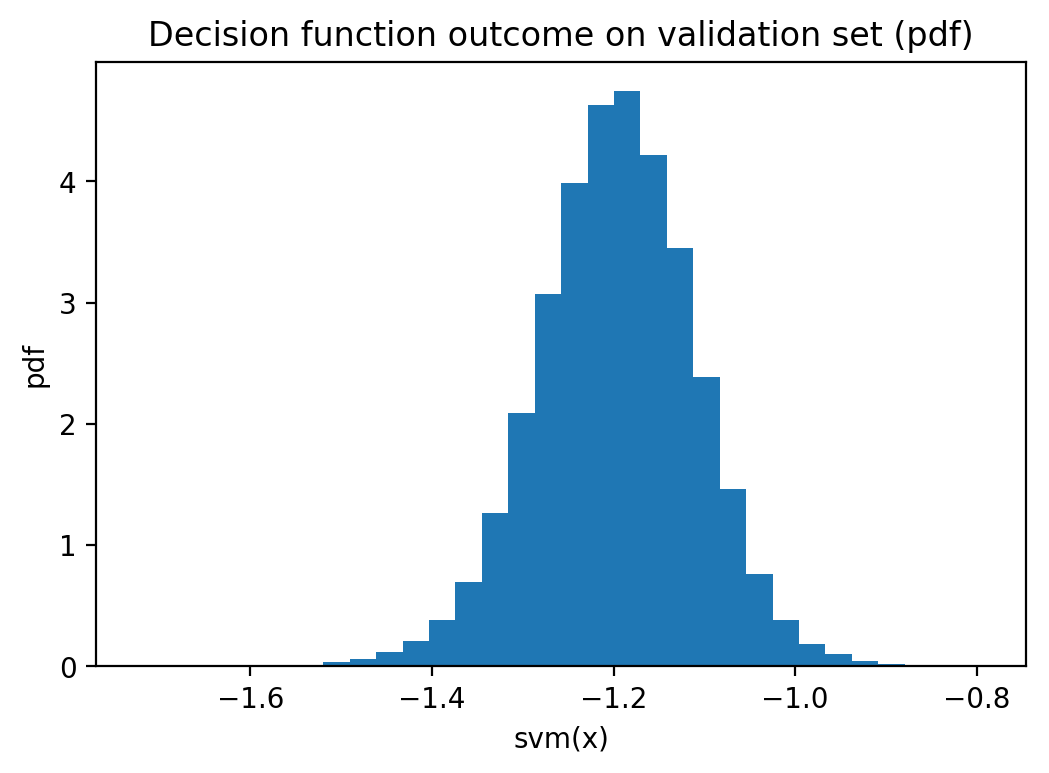

In [36]:
print(min(aggregate))
print(max(aggregate))
plt.figure()
plt.hist(aggregate, 32, normed=True)
plt.title('Decision function outcome on validation set (pdf)')
plt.xlabel('svm(x)')
plt.ylabel('pdf')
plt.show()

AUC: 0.697722223766


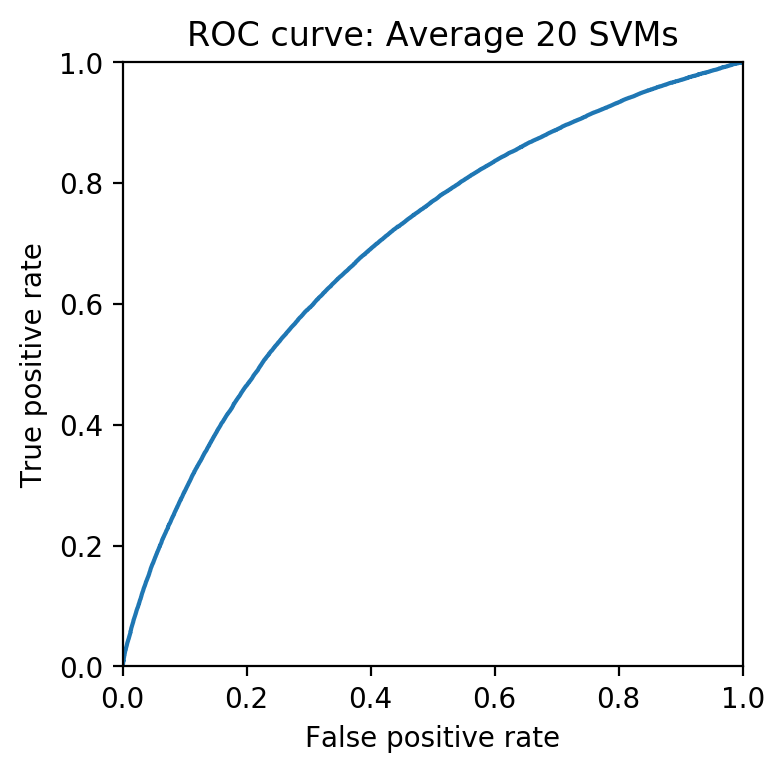

In [37]:
from sklearn.metrics import roc_curve, roc_auc_score

# Evaluate.
def evaluate(decision_fn, title):
    fpr, tpr, thresholds = roc_curve(y_valid, decision_fn)
    auc = roc_auc_score(y_valid, decision_fn)

    print('AUC: {0}'.format(auc))

    plt.figure(figsize=(4,4))
    plt.plot(fpr, tpr)
    plt.title('ROC curve: ' + title)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.show()
evaluate(aggregate, 'Average 20 SVMs')